# Niche based PILOT trajectory inference

**NicheSphere** is an sc-verse compatible Python library which allows the user to find differentially co-localized cellular niches and biological processes involved in their interactions based on cell type pairs co-localization probabilities in different conditions. Cell type pair co-localization probabilities are obtained in different ways: from deconvoluted Visium 10x / PIC-seq data (probabilities of finding each cell type in each spot / multiplet), or counting cell boundaries overlaps for each cell type pair in single cell spatial data (MERFISH , CODEX ...). This tutorial will use groups of cells that converge or split in disease (Ischemia) based on differential co-localization which were defined using NicheSphere.

**PILOT** allows sample level trajectory analysis based on cell type proportions using optimal transport. 

In this tutorial we will **leverage PILOT trajectory inference** adding spatial information by **using NicheSphere resulting niches** to calculate distances between samples.


## 1. Libraries and functions

In [1]:
import pilotpy as pl
import scanpy as sc
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import mudata as md

During startup - Warning messages:
1: Setting LC_MONETARY failed, using "C" 
2: Setting LC_PAPER failed, using "C" 
3: Setting LC_MEASUREMENT failed, using "C" 


## 2. Data at first glance

In this example we will use the **Visium** data from the Myocardial Infarction atlas from Kuppe, C. et. Al., 2022

In [2]:
mudata=md.read('heart_MI_ST_SC_23samples.h5mu')

**Conditions**

We will need the following metadata to subset the samples in different conditions. This table contains a **sample** column with sample names , and a **sampleType** column with the corresponding conditions. 

In [3]:
sampleTypesDF=pd.read_csv('./MI_sampleTypesDF.csv', index_col=0)

For the **coloc tutorial** we did cell type deconvolution on the visium slices using the associated scRNA-seq data, obtaining a cell types x spots matrix of probabilities of each cell type for each spot.

In [4]:
CTprops=pd.read_csv('./CTprops.csv', index_col=0)

Then, we computed cell type pair co-localization probabilities per sample from these cell type probabilities.

In [5]:
coloc=pd.read_csv('./colocPerSample.csv', index_col=0)
coloc.head()

,Fib1_SCARA5-Fib1_SCARA5,Fib1_SCARA5-damaged_CM,Fib1_SCARA5-Capillary_Endo,Fib1_SCARA5-LYVE_FOLR_Macrophages,Fib1_SCARA5-Fib3_C7,Fib1_SCARA5-healthy_CM,Fib1_SCARA5-Fib2_Myofib,Fib1_SCARA5-Endocardial_Endo,Fib1_SCARA5-Arterial_Endo,Fib1_SCARA5-Neuronal,...,NK_T-CCL18_Macrophages,NK_T-perivascular_fibroblasts,NK_T-CD_4,NK_T-vSMCs_2,NK_T-Lymphatic_Endo,NK_T-NK,NK_T-CD_8,NK_T-Purkinje_fibers,NK_T-Adipo,NK_T-NK_T
control_P17,0.017603,0.000308,0.000992,0.000251,0.007062,0.002586,0.004724,0.000943,0.000412,0.000351,...,2.290066e-15,0.0,3.915381e-05,0.0,0.0,4.538656e-08,4.556003e-08,0.0,0.000000e+00,0.000268
RZ_P9,0.009307,0.000429,0.000738,0.000003,0.005204,0.001439,0.001625,0.000065,0.000168,0.000046,...,0.000000e+00,0.0,4.640548e-05,0.0,0.0,9.954633e-05,1.643486e-05,0.0,0.000000e+00,0.000784
IZ_P15,0.030351,0.000000,0.000027,0.000186,0.001200,0.000000,0.003112,0.000072,0.000062,0.000000,...,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000
RZ_P6,0.040470,0.000441,0.002752,0.000361,0.008687,0.002928,0.007878,0.000176,0.001022,0.001170,...,0.000000e+00,0.0,7.998369e-25,0.0,0.0,8.593925e-28,0.000000e+00,0.0,0.000000e+00,0.000438
RZ_BZ_P3,0.021508,0.000292,0.000567,0.000057,0.002408,0.000483,0.006635,0.000123,0.000052,0.000052,...,0.000000e+00,0.0,0.000000e+00,0.0,0.0,8.585311e-06,0.000000e+00,0.0,7.294563e-35,0.000897


We have some duplicated columns; as co-localization between cellType_A-cellType_B is the same as between cellType_B-cellType_A , the corresponding columns have the same values. To avoid using values twice, we remove duplicated columns and multiply the values of the equivalent columns *2.

In [6]:
cell_types=CTprops.columns
oneCTints=cell_types+'-'+cell_types ## same cell type interactions

In [7]:
coloc=coloc.T.drop_duplicates()
coloc=coloc.T
coloc[np.setdiff1d(coloc.columns, oneCTints)]=coloc[np.setdiff1d(coloc.columns, oneCTints)]*2

In the **coloc tutorial** , we compared co-localization probabilities of cell type pairs between **myogenic** and **ischemic** samples. We found 4 differential co-localization niches of cell types that get together or separate in ischemic heart disease compared to control samples.

In [8]:
niches_df=pd.read_csv('./niches_df_MIvisium_louvain.csv')

In [9]:
# we need categorical data
niches_df['niche']=niches_df['niche'].astype('category')

Now, we would like to use PILOT to compute a myogenic to ischemic **disease trajectory** and find out how the **niche proportions** and other features, like the **cell type pair co-localization probabilities**, change along disease progression

## 3. Prepare data for PILOT

To apply PILOT, we need data of **niche** , **sample** and **condition** for each Visium spot. So we'll make a data frame where the niches , as well as condition and sample name for each spot will be stored

In [10]:
all_niches=pd.DataFrame()
for smpl in  sampleTypesDF['sample'].unique():
    tmp=mudata['visium'][mudata['visium'].obs.patient_region_id==smpl].copy()
    tmp.obs['status']=list(sampleTypesDF.sampleType[sampleTypesDF['sample']==smpl])[0]
    ## we'll get the main niche for each spot according to its cell type proportions 
    ## get niche probabilities per spot
    for niche in list(niches_df.niche.cat.categories):
        tmp.obs[niche]=CTprops[list(niches_df.cell[niches_df.niche==niche])].sum(axis=1)
    niche_props=tmp.obs[list(niches_df.niche.cat.categories)]
    ## assigned niche is the one with the highest proportion
    tmp.obs['niche']= [niche_props.columns[np.argmax(niche_props.loc[idx])] for idx in niche_props.index]
    tmp.obs.niche=tmp.obs.niche.astype('category')
    for c in np.setdiff1d(list(niches_df.niche.cat.categories),tmp.obs.niche.cat.categories):
        tmp.obs.niche = tmp.obs.niche.cat.add_categories(c)
    tmp.obs.niche=tmp.obs.niche.cat.reorder_categories(list(niches_df.niche.cat.categories))
    ## fill data frame
    all_niches=pd.concat([all_niches, tmp.obs[['niche', 'patient_region_id', 'status']]])

As remote samples are usually healthy tissue from a diseased patient, we will simplify the annotation and call remote samples myogenic, such as the controls

In [11]:
all_niches['status']=['myogenic' if x=='remote' else x for x in all_niches['status']]

This will be the obs of the anndata we'll use as input for PILOT. 

In [12]:
adata=mudata['visium'].copy()
adata.obs=all_niches

We'll add the cell type proportions to the obsm slot as well, as we'll use them to calculate niche to niche distances (cost matrix) with PILOT

In [13]:
adata.obsm['CTprops']=CTprops.loc[all_niches.index]
adata.obsm['CTprops']=adata.obsm['CTprops'].fillna(0) ## no NAs
adata

AnnData object with n_obs × n_vars = 73904 × 11704
    obs: 'niche', 'patient_region_id', 'status'
    var: 'features'
    obsm: 'X_pca', 'X_spatial', 'X_umap', 'CTprops'

## 4. PILOT 
We will use PILOT to compute a **disease trajectory** based on niche proportions per sample.

Let's start by calculating **distances between samples** using niche proportions with PILOT's **wasserstein_distance** function (slightly modified, see above). These distances are calculated using a cost matrix based on niche to niche distances, will be computed on the cell type proportions per niche.

In [14]:
pl.tl.wasserstein_distance(
    adata,
    emb_matrix = 'CTprops', ## embedding matrix to calculate group to group distances/costs
    clusters_col = 'niche',
    sample_col = 'patient_region_id',
    status = 'status',
    use_centroids=False
    )

**Trajectory of disease progression**

The next step to get our disease progression trajectory is computing a **Diffusion map** on the **Wasserstein distances** calculated before. Now we can show our samples in this embedding. Different conditions are shown in different colors. 

In [15]:
## conditions color list
clist=['#ffadad', '#9bf6ff', '#caffbf', '#bdb2ff']

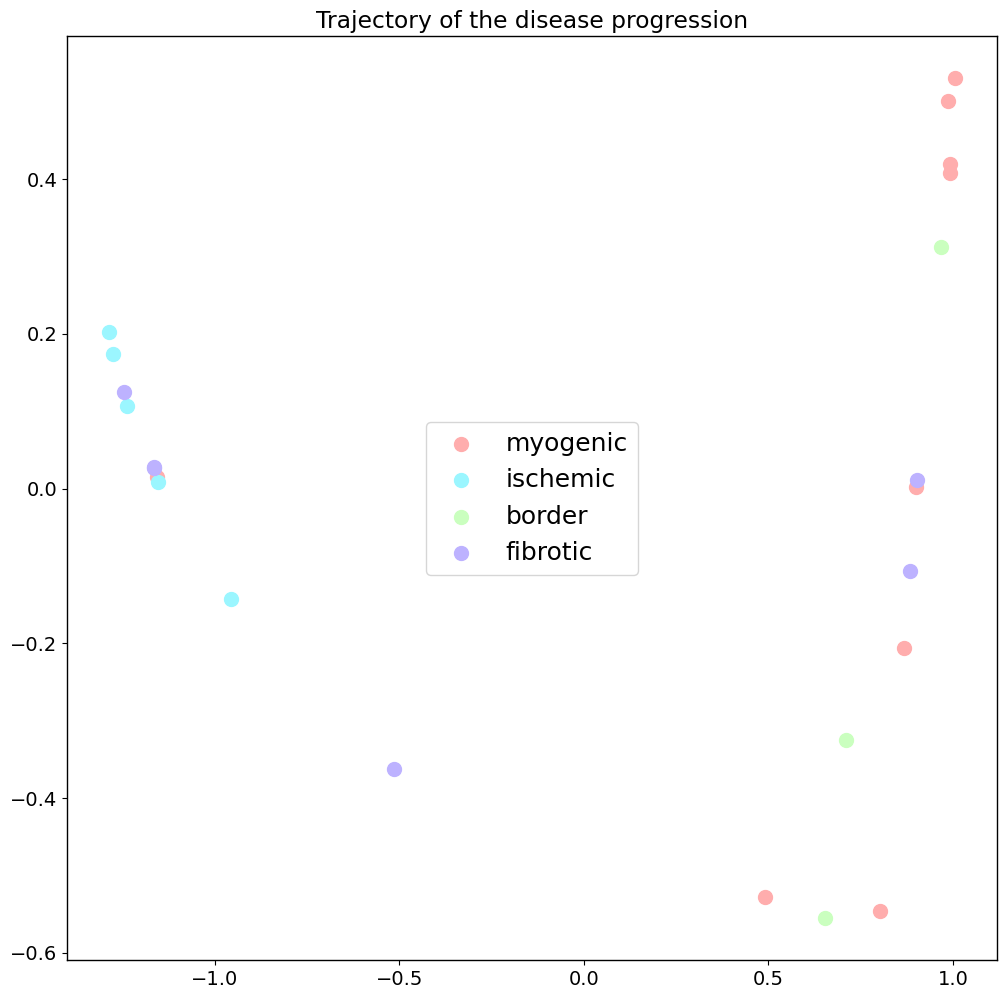

In [16]:
pl.pl.trajectory(adata, 
                 colors=clist, 
                 font_size=14, 
                 location_labels='center', 
                 fontsize_legend=18, 
                 knn=8) ## number of nearest neighbors considered when the kernel (for the diffusion map) is computed

**Principal graph** 

The difussion map creates an embedding that potentially reveals a trajectory in the data. Next, PILOT explores EIPLGraph to **find the structure of the trajectory**. For this, we need to pick a source node. This will also compute a **pseudotime** and order samples along it

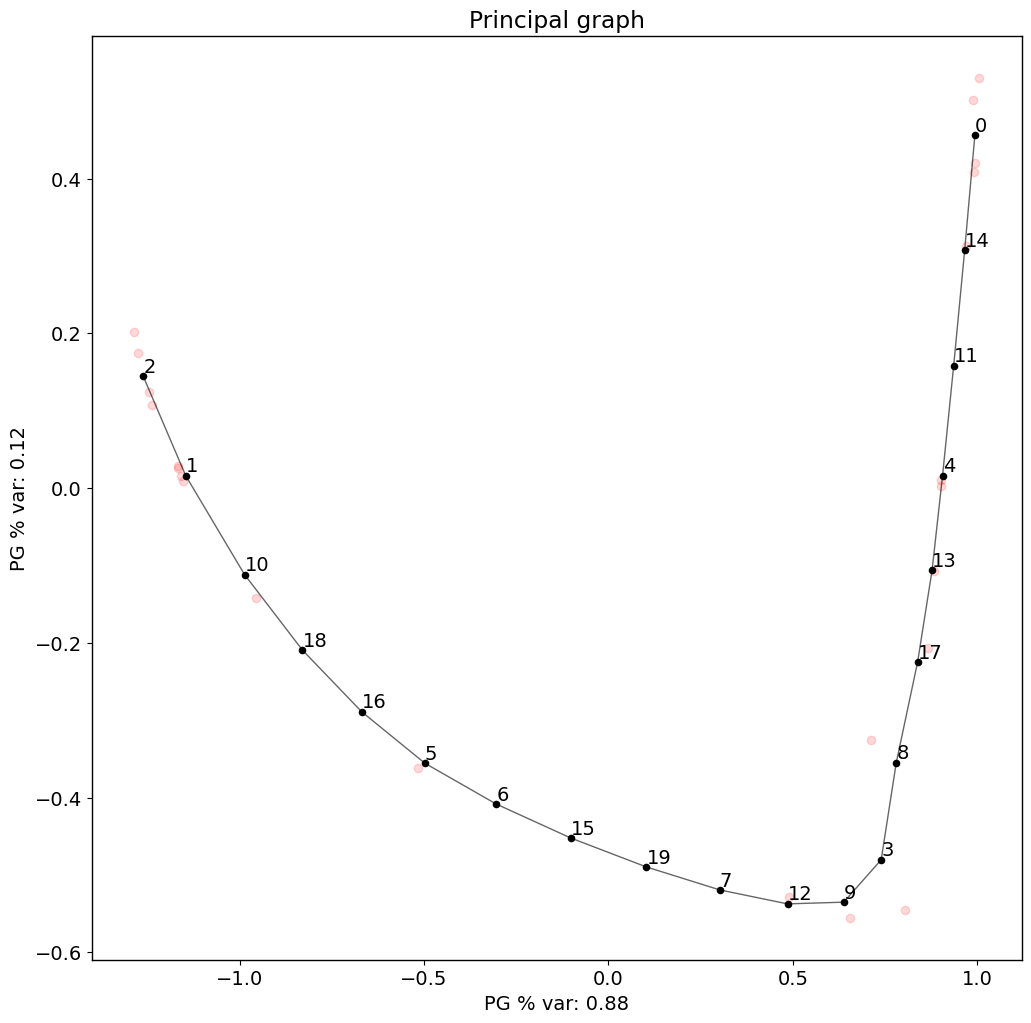

In [17]:
pl.pl.fit_pricipla_graph(adata, source_node = 0)

In [18]:
## Samples sorted by pseudotime
PT=pd.Series(adata.uns['pseudotime'], index=list(adata.uns['proportions'].keys())).sort_values()

## 5. Interpretability

## 5.1 Niche changes along trajectory

Now we have a niche proportions based disease trajectory and pseudotime, and can sort the samples along it. From here, we can ask different questions, like **how do individual niche proportions change along the trajectory?** and **which niches could be disease-related?** 

To have a look into this, we can apply the robust regression model to find niches whose proportions change linearly or non-linearly with disease progression using the **cell_importance** function from PILOT.

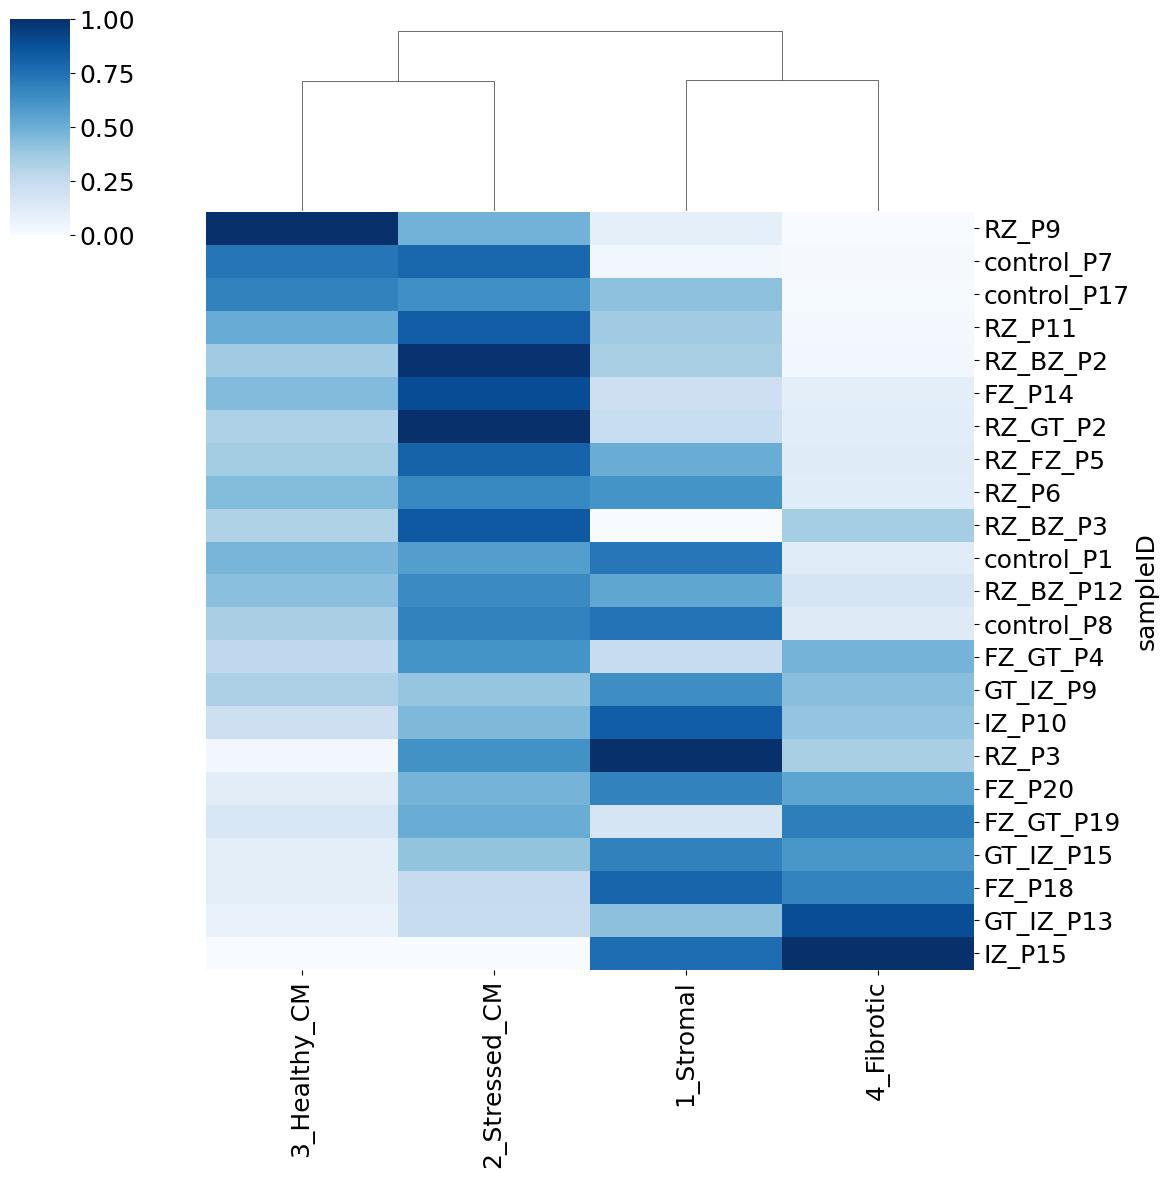

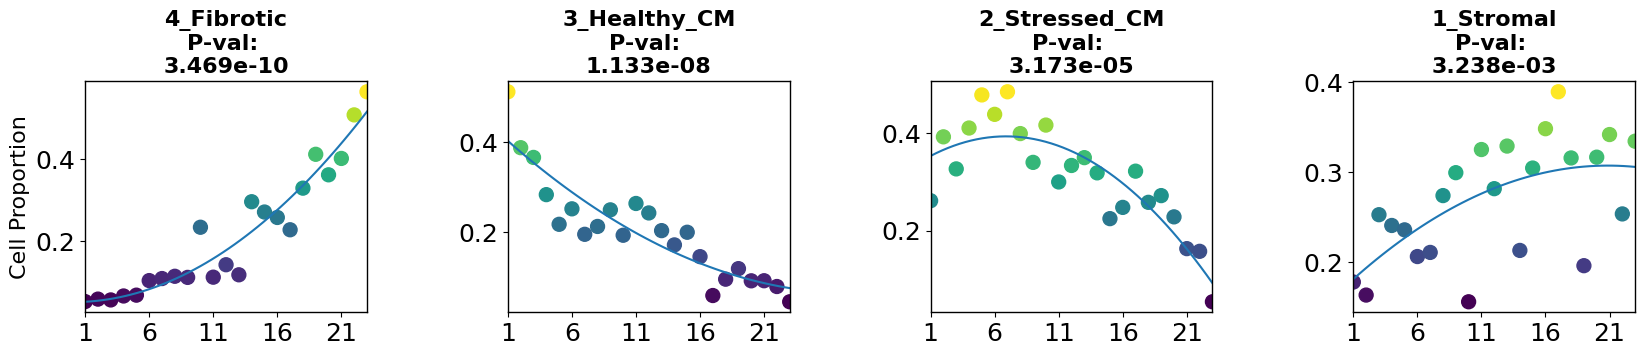

In [19]:
plt.rcParams.update({'font.size': 18})
pl.tl.cell_importance(adata,
                height=3, ## for the individual group scatter plots below
                width=20, ## for the individual group scatter plots below
                fontsize=16,)

## 5.2 Visium slices along trajectory

To visualize the niche changes in the Visium slices along the trajectory, we can also plot the niches in the visium slices , save the images and plot them on a grid, sorted by pseudotime using the **create_sample_grid** function.

In [20]:
## assign niche colors
col_list=['#4daf4a', '#0072B5', '#BC3C29', '#ffff33']
adata.uns['niche_colors']=col_list

In [21]:
## niches on slices images
for smpl in  list(sampleTypesDF['sample']):  
    sc.pl.spatial(adata=adata[adata.obs.patient_region_id==smpl].copy(), 
                  color='niche', 
                  img_key=None, 
                  library_id=None,
                  spot_size=0.015, 
                  title='', 
                  frameon=False, 
                  legend_loc=None, 
                  save='_'+smpl+'_niches'+'.png', 
                  legend_fontsize=6, 
                  size=1.5,
                  show=False) ## plots as simple as possible (no background , title , frame, etc)

The niches will be plotted in the following colors:

(0.0, 1.0, 0.0, 1.0)

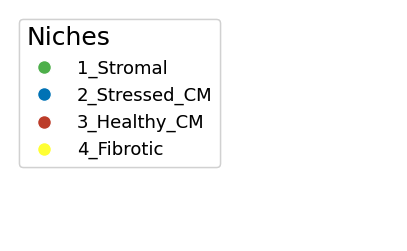

In [22]:
legend_elements1=[plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=col_list[i], lw=4, label=list(adata.obs.niche.cat.categories)[i], ms=10) for i in range(len(list(adata.obs.niche.cat.categories)))]
fig, ax = plt.subplots(figsize=(5,3))
plt.gca().add_artist(plt.legend(handles=legend_elements1,loc='upper left', fontsize=13, title='Niches', alignment='left'))
ax.axis('off')

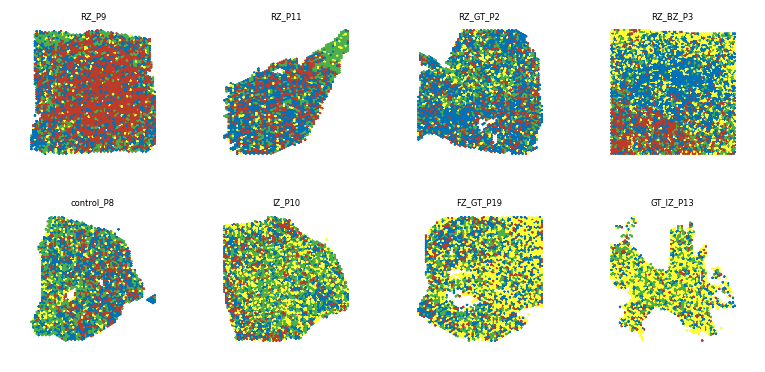

Saved grid to ./Results_PILOT/Cores_niches.pdf


In [23]:
## Put on grid sorted by pseudotime
pl.pl.create_sample_grid(df=adata.uns['orders'][::3], ## dataframe with a sampleID and a Time_score column (created by PILOT)
                   pattern = 'niches', ## slice plots are stored as 'show_{sample}_{pattern}.png'
                   image_dir='./figures/', ## where the slice plots are stored
                   output_path='./Results_PILOT/Cores_niches.pdf', 
                   zoom=0.27, 
                   num_rows=2) ## number of rows in the grid

## 5.3 Pairwise cell-cell co-localization along trajectory

We can also ask if **other features** are relevant for disease progression. In this case, a relevant question is which **cell type pairs coloc probability** is relevant for disease progression. As there are too many cell type pairs to plot all of them, we'll select some of them based on their correlation with pseudotime.

In [24]:
### correlation of colocs with pseudotime
pvals=[scipy.stats.spearmanr(coloc[c][PT.index], PT).pvalue for c in coloc.columns]
stat=[scipy.stats.spearmanr(coloc[c][PT.index], PT).statistic for c in coloc.columns]
## make data frame
df=pd.DataFrame([coloc.columns, stat, pvals], index=['pairs', 'statistic', 'p-value']).T
df.index=df.pairs

In [25]:
df=df.sort_values(by='p-value')
df=df[['statistic', 'p-value']].reset_index()

Now we can subset the coloc matrix according to trajectory correlation statistics. This data, as well as the cell pair names, will be stored in the anndata uns slot .

In [26]:
## top cell type pairs positively correlated with trajectory
pairs_to_plot_pos=list(df[(df['p-value']<0.05)&(df.statistic>0.6)]['pairs'])
pairs_to_plot_pos=list(np.setdiff1d(pairs_to_plot_pos, oneCTints)[0:4])

In [27]:
## top cell type pairs negatively correlated with trajectory
pairs_to_plot_neg=list(df[(df['p-value']<0.05)&(df.statistic<(-0.6))]['pairs'])
pairs_to_plot_neg=list(np.setdiff1d(pairs_to_plot_neg, oneCTints)[0:4])

In [28]:
## subset coloc matrix
coloc_sub_=coloc[pairs_to_plot_pos+pairs_to_plot_neg]
## store selected pairs in anndata uns
adata.uns['coloc_names']=list(coloc_sub_.columns)

Coloc probabilities must be stored as a dictionary with cell pairs as keys to apply the **feature_importance** function (a modified version of the **cell_importance** function of PILOT to plot any sample feature along the trajectory)

In [29]:
## convert selected coloc probabilities data frame into a dictionary and store it in the anndata uns
coloc_dict = dict(zip(coloc_sub_.index, coloc_sub_.values))
adata.uns['proportions_coloc']=coloc_dict

We can use the robust regression model to find features which change linearly or non-linearly with disease progression using the **feature_importance** function

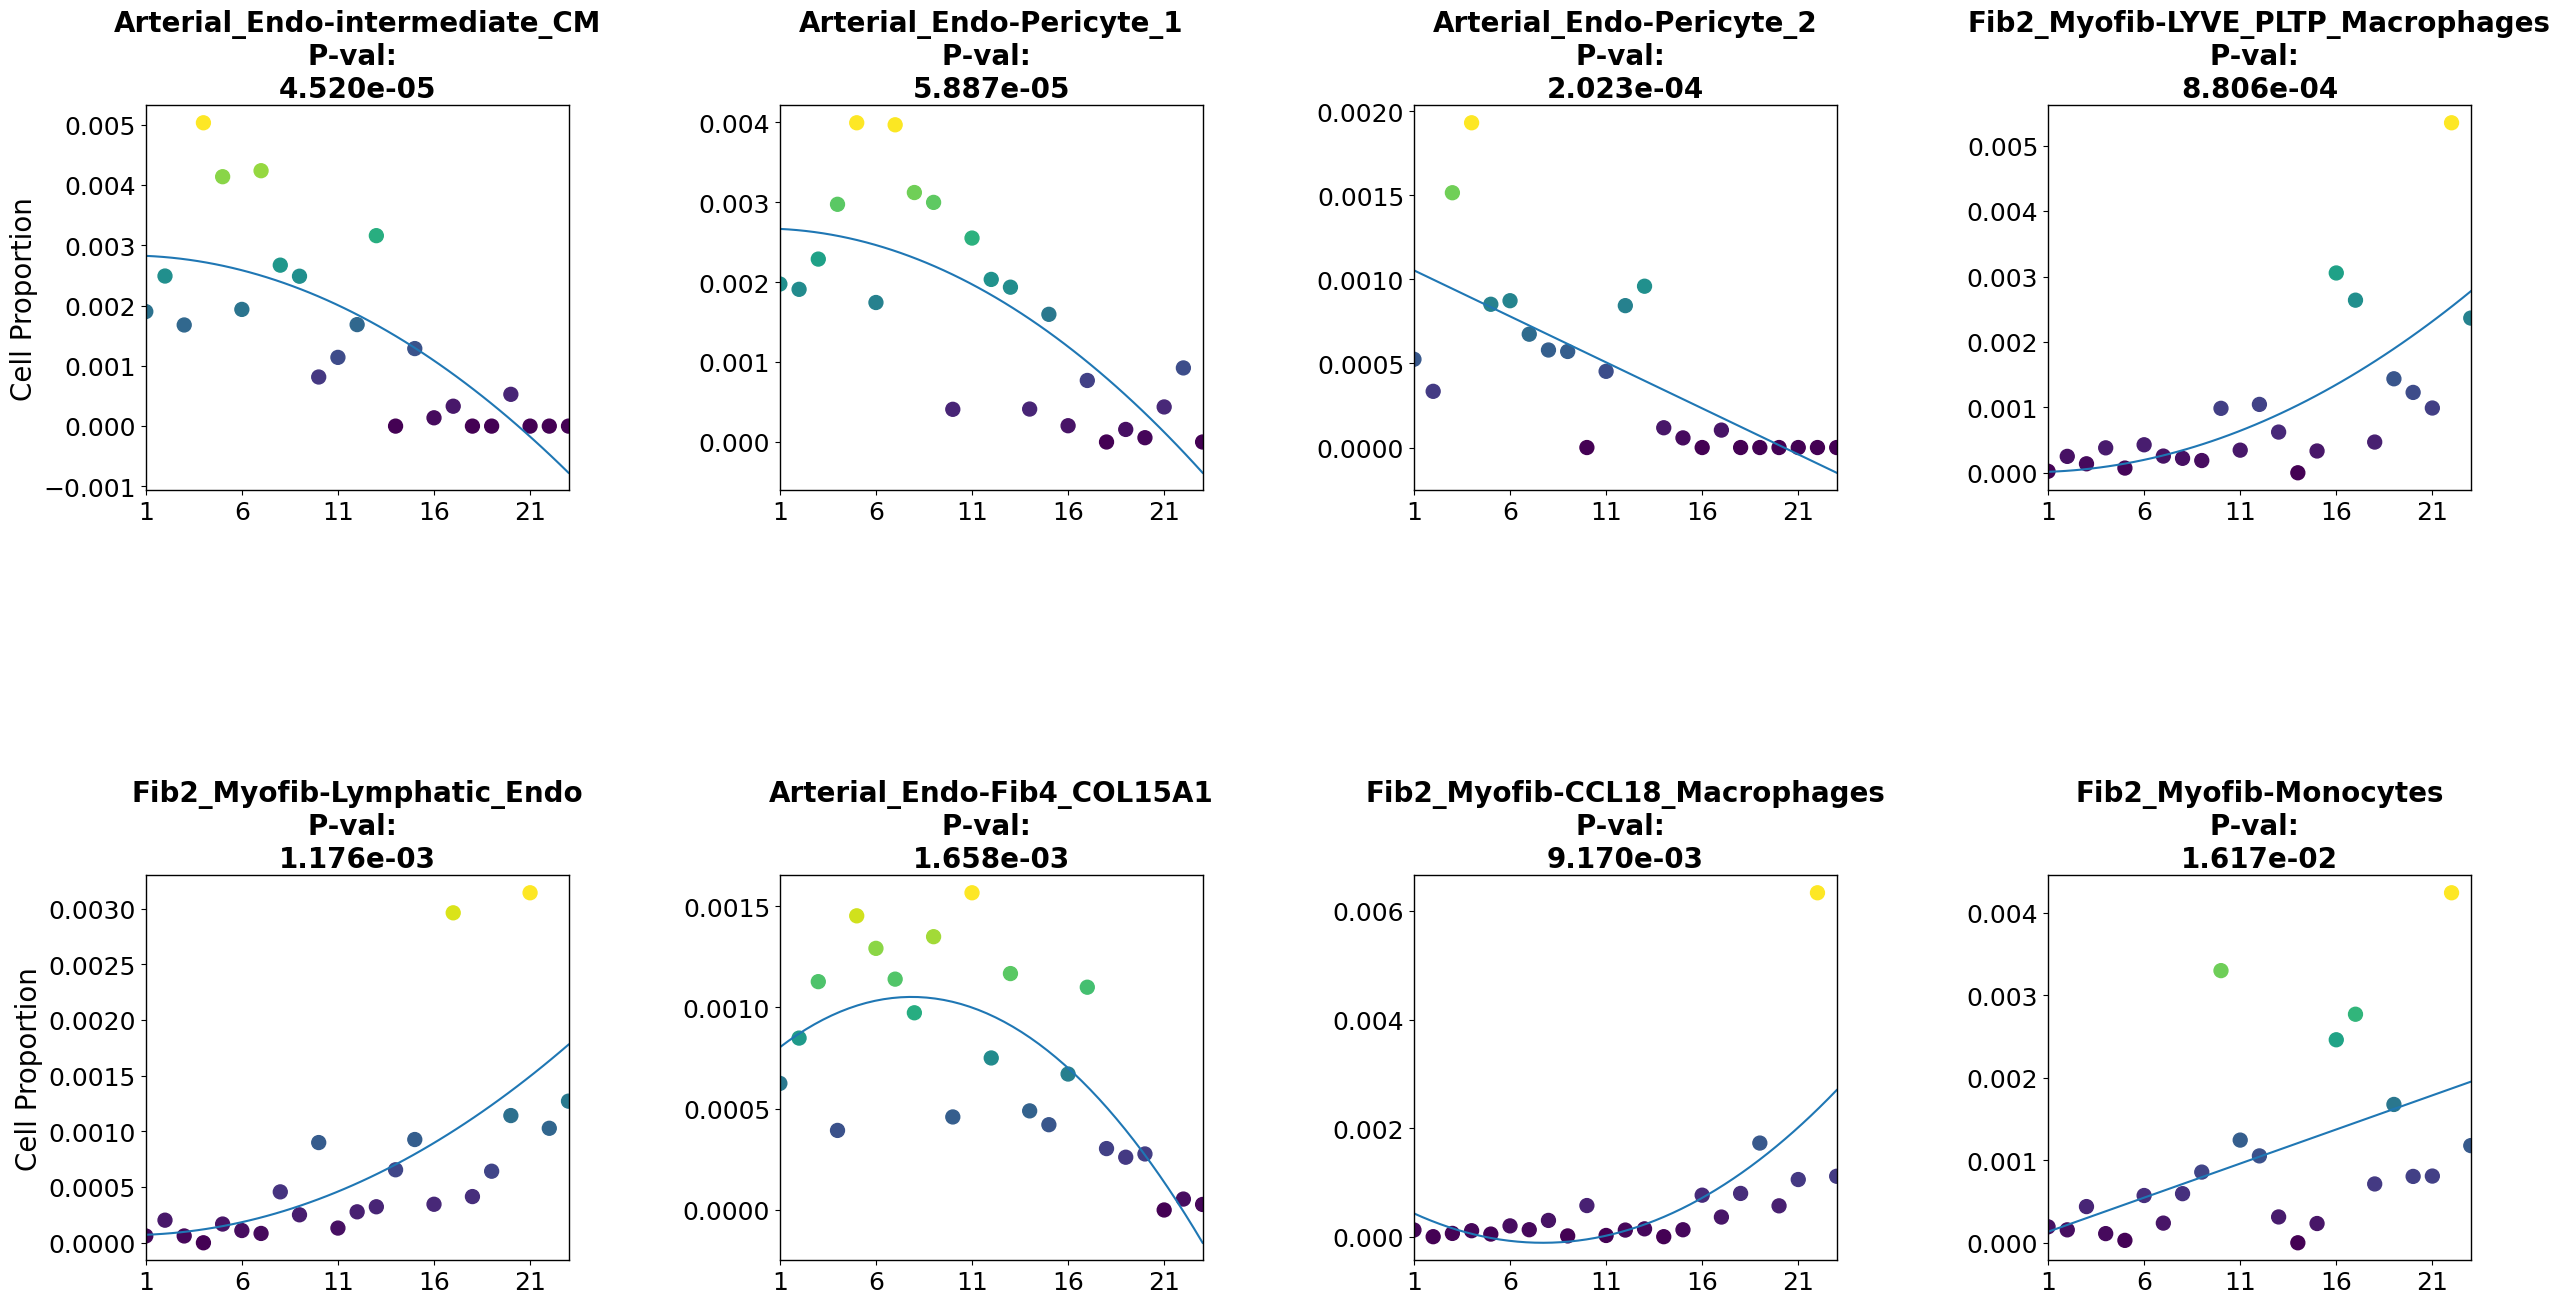

In [30]:
pl.tl.feature_importance(adata, 
                   feature_matrix='proportions_coloc', ## anndata slot where our dictionary with features of interest per sample is
                   feature_names='coloc_names', ## anndata slot where these features' names are stored
                   height=15,width=30, ## image dimensions
                   fontsize = 20,
                   figsize=(6,6))
plt.savefig('./figures/cell_pairs_scatter.pdf')